In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-454'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Project_1/dmc2010_train.txt'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
coupons = pd.read_csv(file_content_stream, sep = ';')
coupons.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,...,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
0,41191,2008-12-01,0,0,9,2008-12-01,0,2,2,0,...,0,0,0,0,0,0,0,0,0,0
1,38860,2008-12-16,1,0,4,2008-12-16,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,61917,2008-08-19,0,0,12,2008-08-19,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,40647,2008-06-16,1,0,8,2008-06-16,0,1,0,0,...,0,0,0,2,0,0,0,0,0,0
4,1347,2008-08-08,0,0,1,2008-08-08,0,1,1,1,...,2,0,0,0,0,0,0,0,0,0


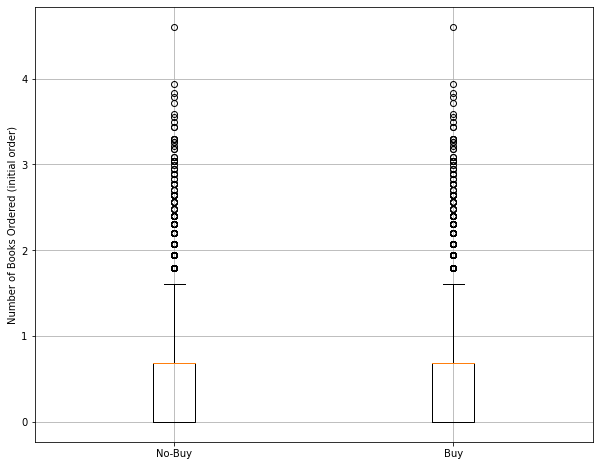

In [3]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
target0 = coupons[coupons['target90'] == 0]
target1 = coupons[coupons['target90'] == 1]

## Creating side-by-side box plots
plt.boxplot([np.log(target0['w0'] + 1), np.log(target0['w0'] + 1)], labels = ['No-Buy', 'Buy'])
plt.ylabel('Number of Books Ordered (initial order)')
plt.grid()

## saving the plot
# plt.savefig('side_by_side_boxplot.pdf')

plt.show()